### Visualization of RGB image and instance mask.

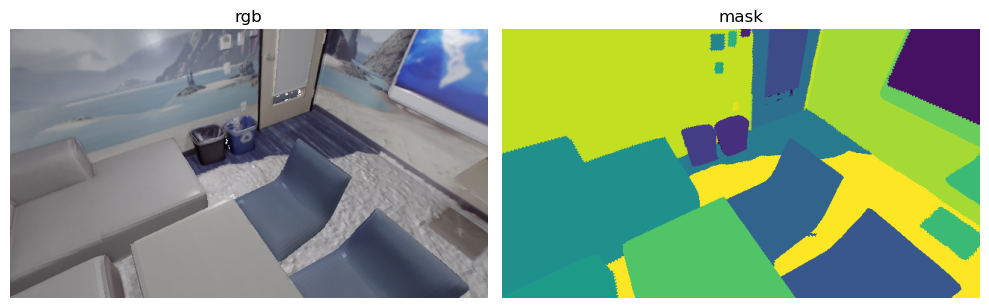

In [1]:
from src.utils.image_processing import load_view
from src.visualization.visualization import plot_imgs, remap_mask

rgb, mask = load_view("data/processed/office0/0")
plot_imgs(rgb, remap_mask(mask), titles=["rgb", "mask"])

### Instance distribution by scene.

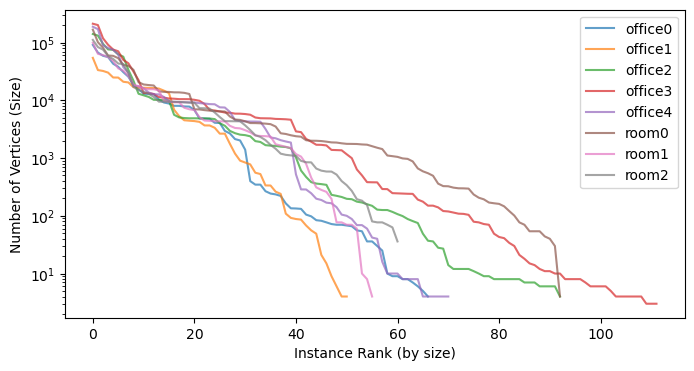

In [2]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

root_path = Path("data/replica/ground_truth")
scenes = ["office0", "office1", "office2", "office3", "office4", "room0", "room1", "room2"]

plt.figure(figsize=(8, 4))

for scene in scenes:
    ids = np.loadtxt(root_path / f"{scene}.txt", dtype='int64')
    ids = ids[ids > 0]  # Ignore background (usually ID -1 or 0)
    _, counts = np.unique(ids, return_counts=True)
    sorted_counts = np.sort(counts)[::-1]
    plt.plot(sorted_counts, label=scene, alpha=0.7)

plt.yscale('log')
plt.xlabel("Instance Rank (by size)")
plt.ylabel("Number of Vertices (Size)")
# plt.title("Object Size Distribution Across Scenes")
plt.legend()
plt.show()

We export these counts to plot them in PGFPlots.

In [3]:
import pandas as pd
import numpy as np
from pathlib import Path

root_path = Path("data/replica/ground_truth")
scenes = ["office0", "office1", "office2", "office3", "office4", "room0", "room1", "room2"]

# We will store the data in a way that LaTeX can read easily
# Since different scenes have different numbers of instances, we save them individually
for scene in scenes:
    ids = np.loadtxt(root_path / f"{scene}.txt", dtype='int64')
    ids = ids[ids > 0]
    _, counts = np.unique(ids, return_counts=True)
    sorted_counts = np.sort(counts)[::-1]
    
    # Save to a simple 2-column CSV
    df = pd.DataFrame({'rank': np.arange(len(sorted_counts)), 'size': sorted_counts})
    df.to_csv(f"plot_data_{scene}.csv", index=False)

### Mistake Rate on Negative Pairs.

In [3]:
import json

def mistakes(mode="base", scene="office4"):
    lines = None
    with open(f"results/qwen3vl_eval/{mode}/{scene}/predictions.jsonl", 'r') as f:
        lines = f.readlines()
    
    overall_mistakes = 0
    negative_mistakes = 0
    
    for line in lines:
        d = json.loads(line)
        if d["prediction"] != d["gt"]:
            overall_mistakes += 1
            if d["is_negative"]:
                negative_mistakes += 1

    return overall_mistakes, negative_mistakes

for mode in ["base", "lora"]:
    for scene in ["office4", "room2"]:
        overall_mistakes, negative_mistakes = mistakes(mode, scene)
        print(f"mode: {mode}, scene: {scene}")
        print('overall mistakes:', overall_mistakes)
        print('negative mistakes:', negative_mistakes)
        print('negative shamistakes\' share:', negative_mistakes / overall_mistakes)
        print()

mode: base, scene: office4
overall mistakes: 78
negative mistakes: 61
negative shamistakes' share: 0.782051282051282

mode: base, scene: room2
overall mistakes: 61
negative mistakes: 47
negative shamistakes' share: 0.7704918032786885

mode: lora, scene: office4
overall mistakes: 53
negative mistakes: 42
negative shamistakes' share: 0.7924528301886793

mode: lora, scene: room2
overall mistakes: 25
negative mistakes: 15
negative shamistakes' share: 0.6



### Qualitative visualizations.

#### Inspecting difficult pairs

In [4]:
import json

root_path = "results/qwen3vl_eval/"
scene = "office4"

with open(f"{root_path}/base/{scene}/predictions.jsonl", "r") as f1:
    lines1 = f1.readlines()
    with open(f"{root_path}/lora/{scene}/predictions.jsonl", "r") as f2:
        lines2 = f2.readlines()
        for i in range(len(lines1)):
            item1 = json.loads(lines1[i])
            item2 = json.loads(lines2[i])
            if item1["prediction"] != item2["prediction"]:
                print(item1)
                print(item2)

{'batch': 4, 'item': 0, 'prediction': 1, 'gt': 1, 'raw_output': 'user\nDo these two image regions belong to the same physical object in the 3D scene? Answer yes or no.\nassistant\nyes', 'view_i': '134', 'view_j': '66', 'inst_i': 20002, 'inst_j': 20002, 'is_negative': False}
{'batch': 4, 'item': 0, 'prediction': 0, 'gt': 1, 'raw_output': 'user\nDo these two image regions belong to the same physical object in the 3D scene? Answer yes or no.\nassistant\nNo', 'view_i': '134', 'view_j': '66', 'inst_i': 20002, 'inst_j': 20002, 'is_negative': False}
{'batch': 7, 'item': 0, 'prediction': 1, 'gt': 0, 'raw_output': 'user\nDo these two image regions belong to the same physical object in the 3D scene? Answer yes or no.\nassistant\nyes', 'view_i': '100', 'view_j': '175', 'inst_i': 47071, 'inst_j': 93056, 'is_negative': True}
{'batch': 7, 'item': 0, 'prediction': 0, 'gt': 0, 'raw_output': 'user\nDo these two image regions belong to the same physical object in the 3D scene? Answer yes or no.\nassista

In [4]:
from src.data.dataset import ReplicaInstancePairDataset
from src.configs.schema import BaseConfig, EvalConfig
from src.utils.setup_utils import load_config, get_base_save_dir

base_cfg = load_config(BaseConfig, "src/configs/base.json")
eval_cfg = load_config(EvalConfig, "src/configs/eval.json")

dataset = ReplicaInstancePairDataset(
    root=base_cfg.paths.processed_root,
    scene=scene,  # office4
    tokenizer=None,
    cfg=eval_cfg.dataset
)

In [15]:
from src.utils.image_processing import load_view, extract_instance_crop
from src.visualization.visualization import plot_imgs, plot_imgs_color

def plot_rgb_mask_crop_pair(root_dir, view_i, view_j, inst_i, inst_j):
    rgb_i, mask_i = load_view(f"{root_dir}/{view_i}")
    rgb_j, mask_j = load_view(f"{root_dir}/{view_j}")
    crop_i = extract_instance_crop(rgb_i, mask_i, inst_i)
    crop_j = extract_instance_crop(rgb_j, mask_j, inst_j)
    plot_imgs(rgb_i, remap_mask(mask_i), crop_i, titles=["rgb", "mask", "cropped mask"])
    plot_imgs(rgb_j, remap_mask(mask_j), crop_j, titles=["rgb", "mask", "cropped mask"])

# Valentin's functions
def rgb_instance_overlay(img, mask, instance_id, is_negative):
  color = np.array([])
  if is_negative:
      color = np.array([255, 0, 0])
  else:
      color = np.array([0, 255, 0])
  inst = (mask == instance_id)
  if not isinstance(img, np.ndarray):
            img = np.array(img)
  inst = (mask == instance_id)
  overlay = img.copy()
  overlay[inst] = (
        overlay[inst] * (0.1) + color * 0.9
    ).astype(np.uint8)
  return overlay

def plot_rgb_overlay_crop_pair(root_dir, view_i, view_j, inst_i, inst_j):
    rgb_i, mask_i = load_view(f"{root_dir}/{view_i}")
    rgb_j, mask_j = load_view(f"{root_dir}/{view_j}")
    is_negative = True
    if inst_i == inst_j:
        is_negative = False
    overlay = rgb_instance_overlay(rgb_i, mask_i, inst_i,is_negative)
    overlay2 = rgb_instance_overlay(rgb_j, mask_j, inst_j, is_negative)
    crop_i = extract_instance_crop(rgb_i, mask_i, inst_i)
    crop_j = extract_instance_crop(rgb_j, mask_j, inst_j)
    plot_imgs(rgb_i, overlay, crop_i, titles=["rgb", "mask", "cropped mask"])
    plot_imgs(rgb_j, overlay2, crop_j, titles=["rgb", "mask", "cropped mask"])

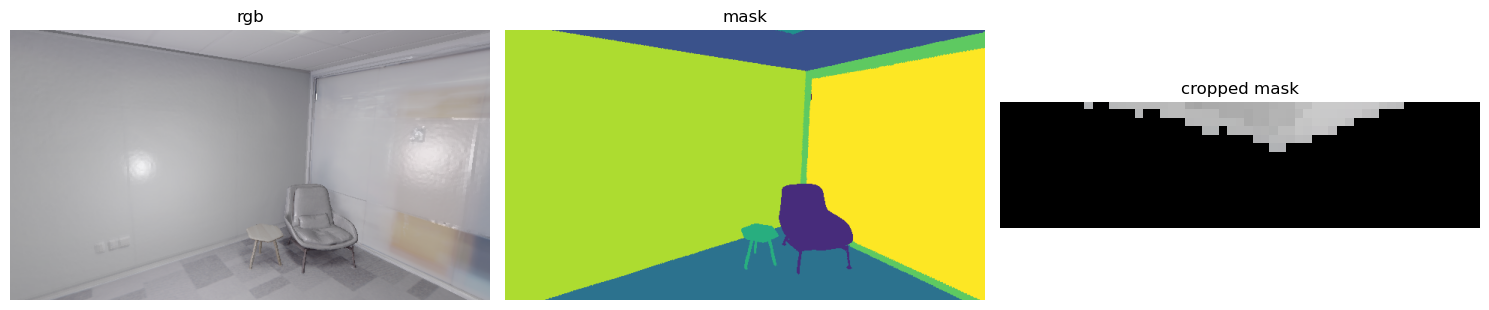

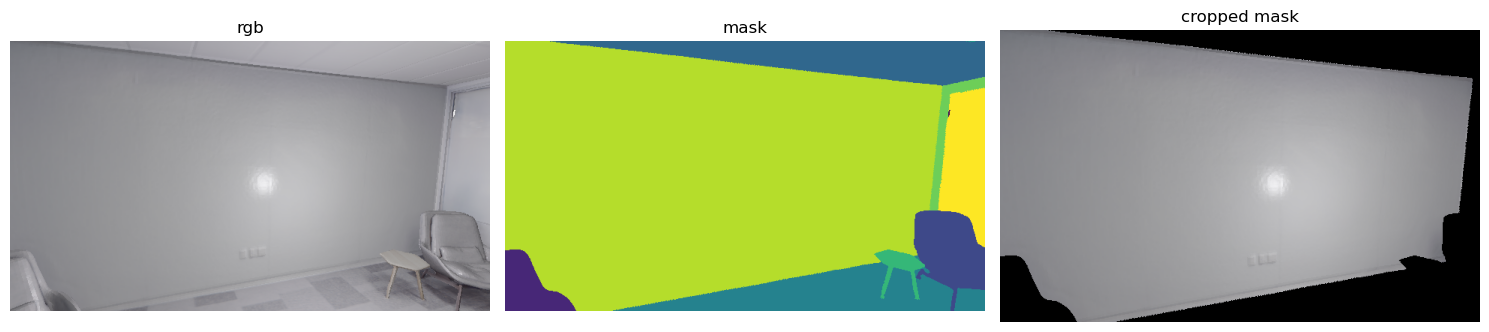

In [6]:
root_dir = "data/processed/office4"
view_i, view_j = 100, 175
inst_i, inst_j = 47071, 93056

plot_rgb_mask_crop_pair(root_dir, view_i, view_j, inst_i, inst_j)

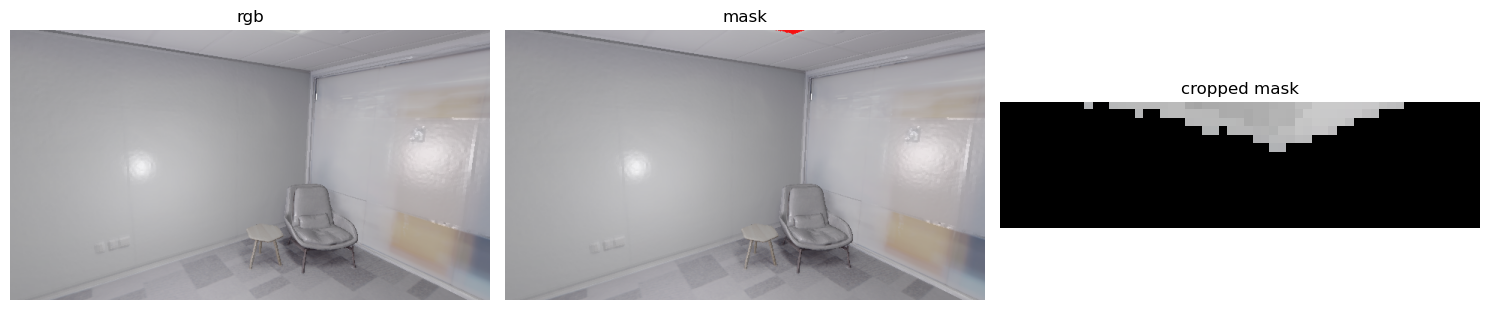

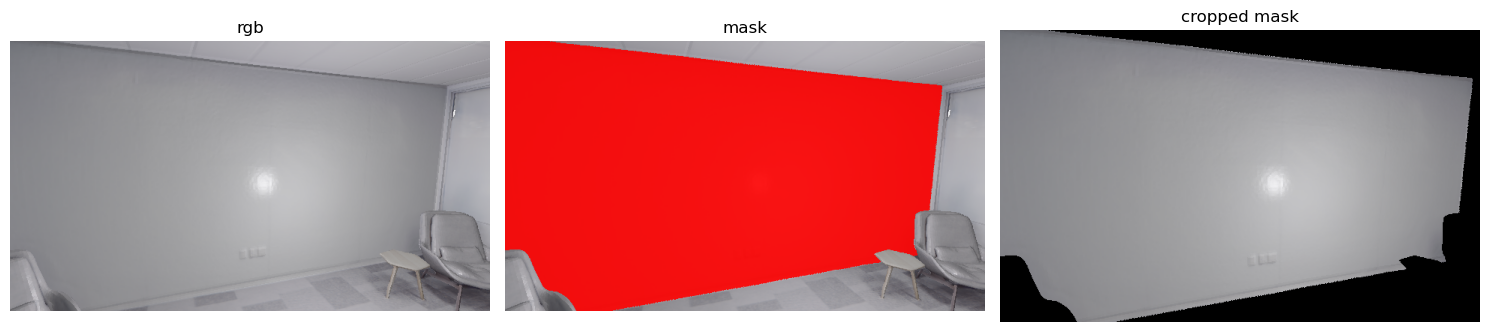

In [9]:
plot_rgb_overlay_crop_pair(root_dir, view_i, view_j, inst_i, inst_j)

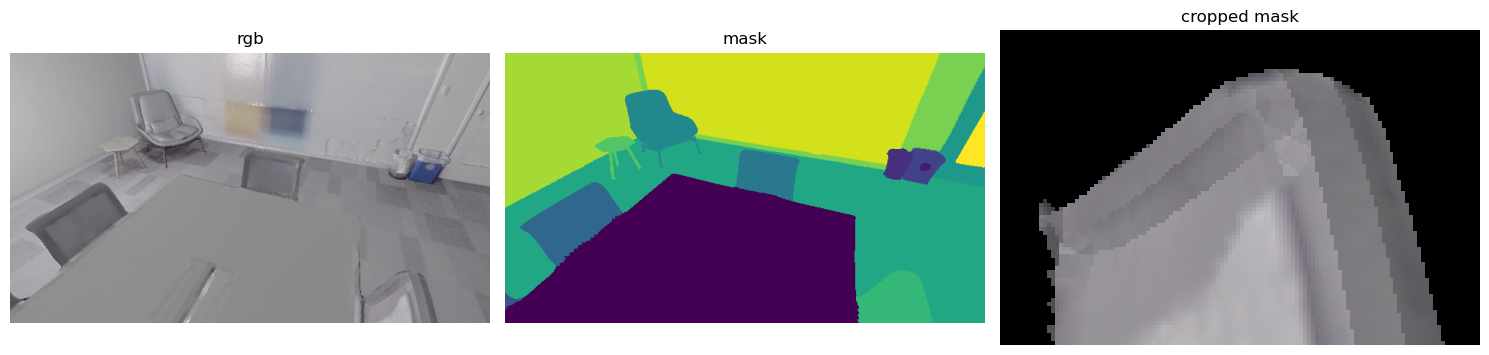

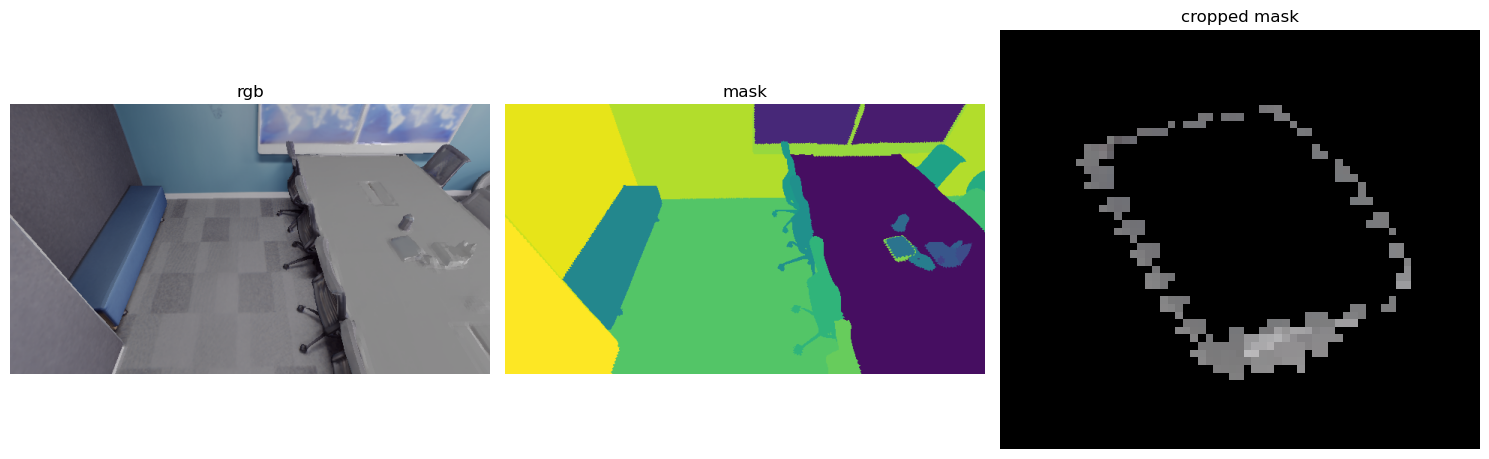

In [9]:
plot_rgb_mask_crop_pair("data/processed/office4", 143, 73, 40014, 56021)

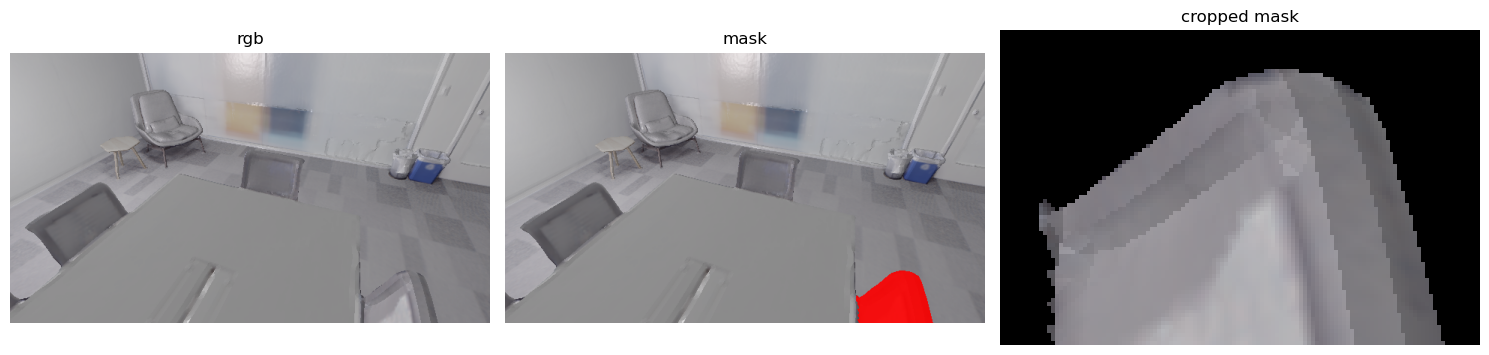

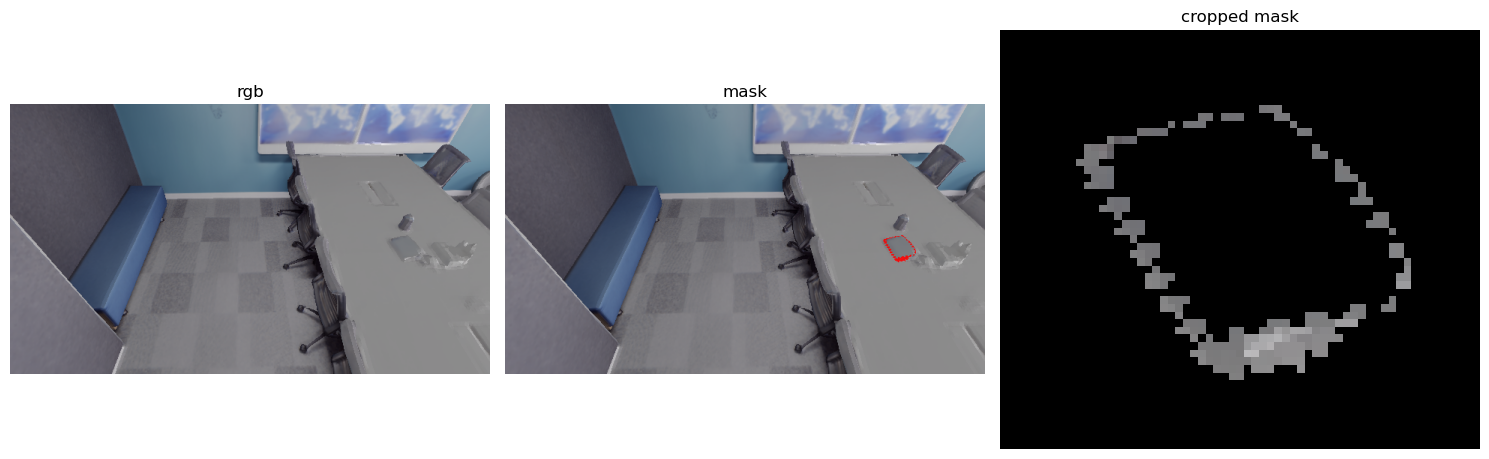

In [10]:
plot_rgb_overlay_crop_pair("data/processed/office4", 143, 73, 40014, 56021)

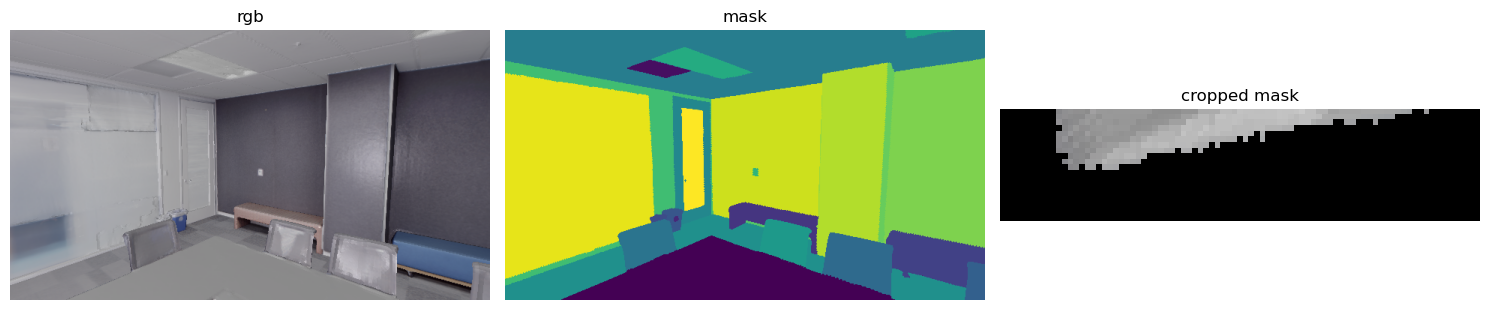

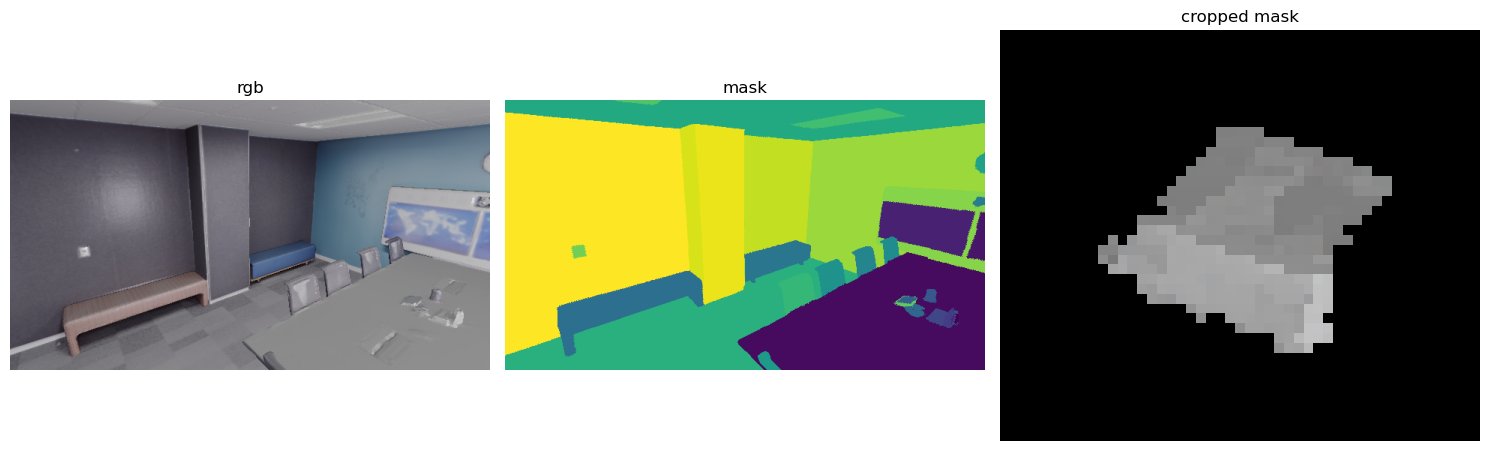

In [10]:
plot_rgb_mask_crop_pair("data/processed/office4", 0, 32, 47048, 39)

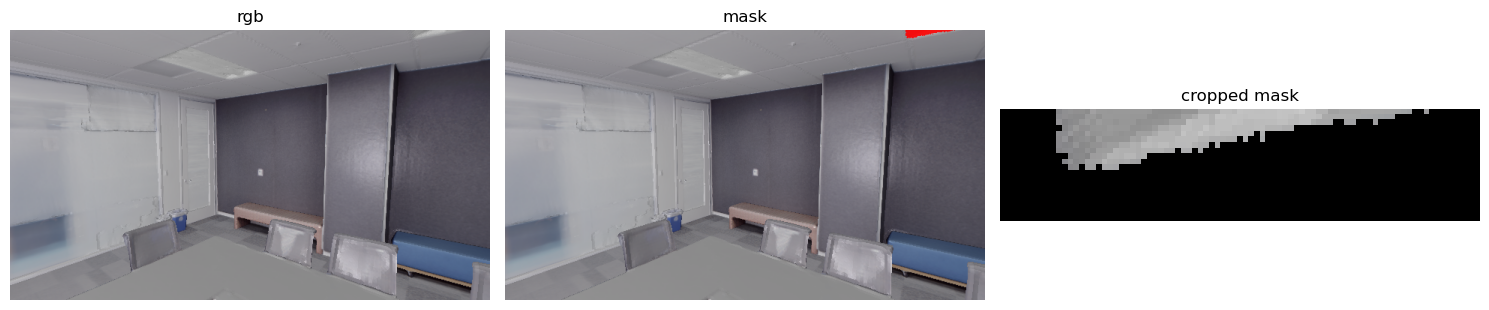

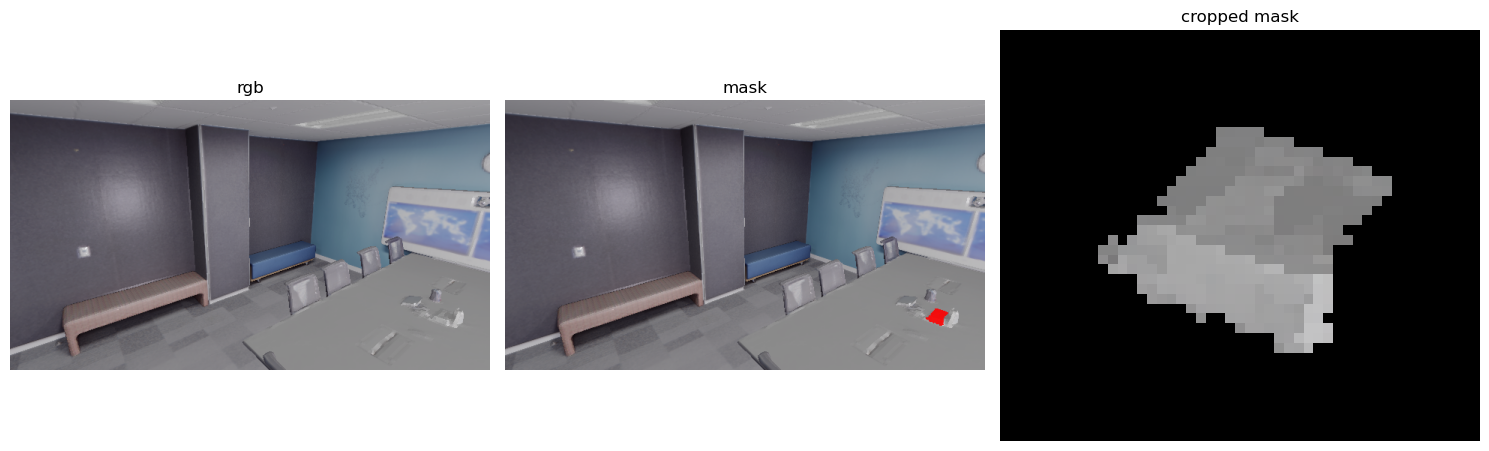

In [11]:
plot_rgb_overlay_crop_pair("data/processed/office4", 0, 32, 47048, 39)

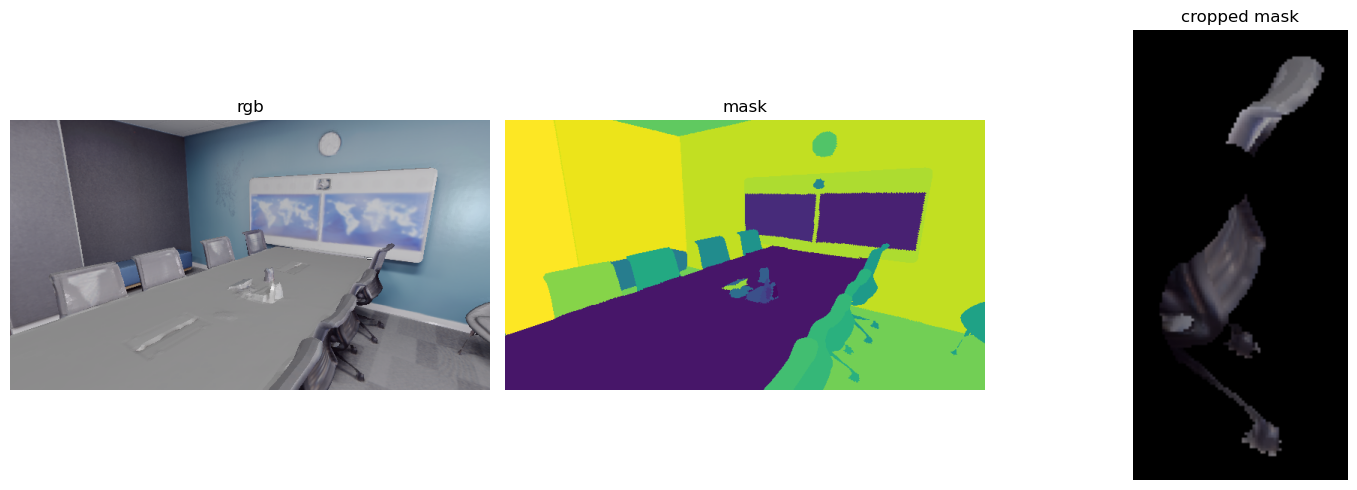

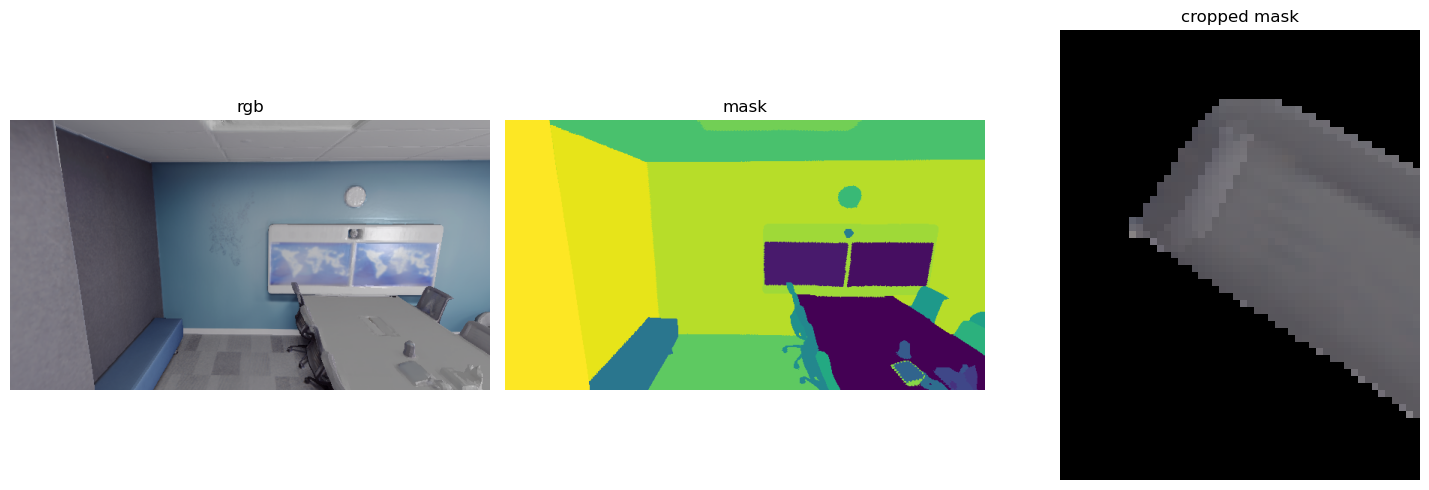

In [11]:
plot_rgb_mask_crop_pair("data/processed/office4", 14, 64, 20017, 20017)

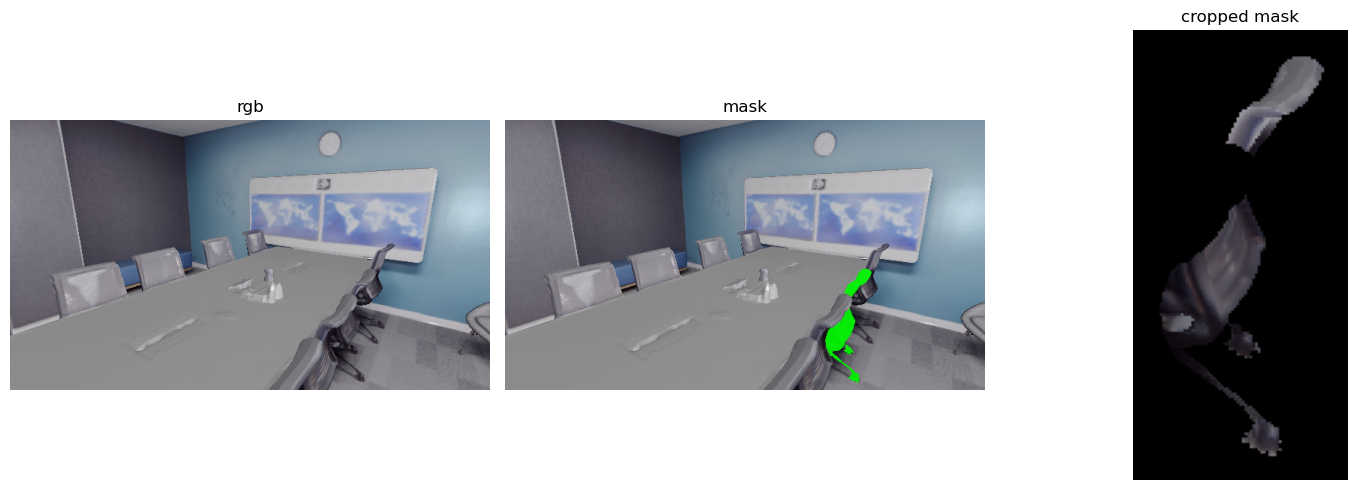

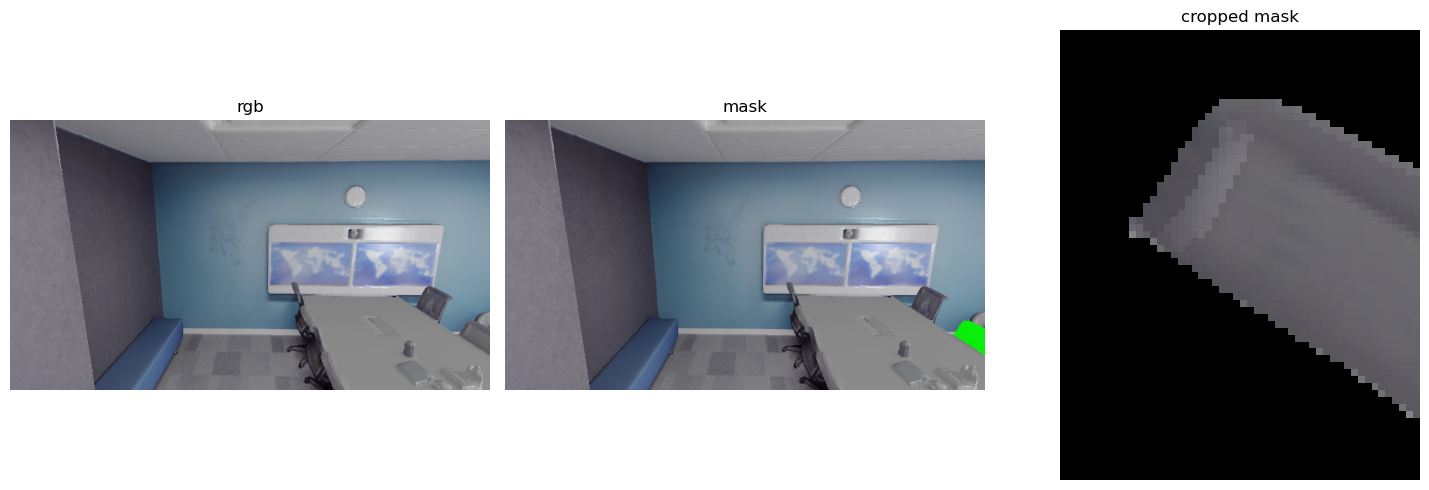

In [12]:
plot_rgb_overlay_crop_pair("data/processed/office4", 14, 64, 20017, 20017)

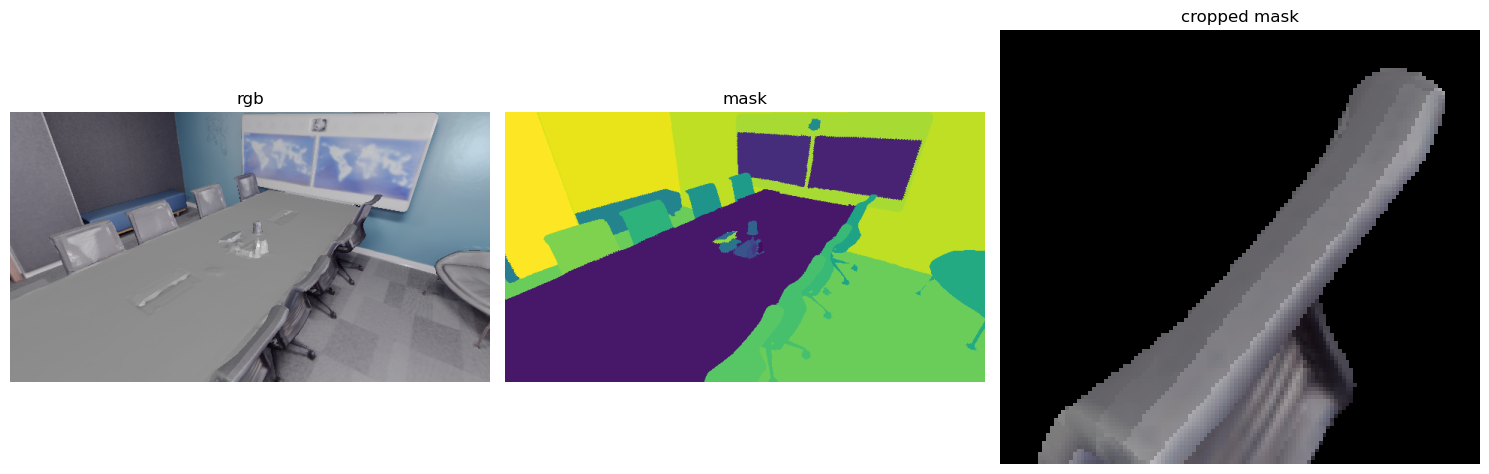

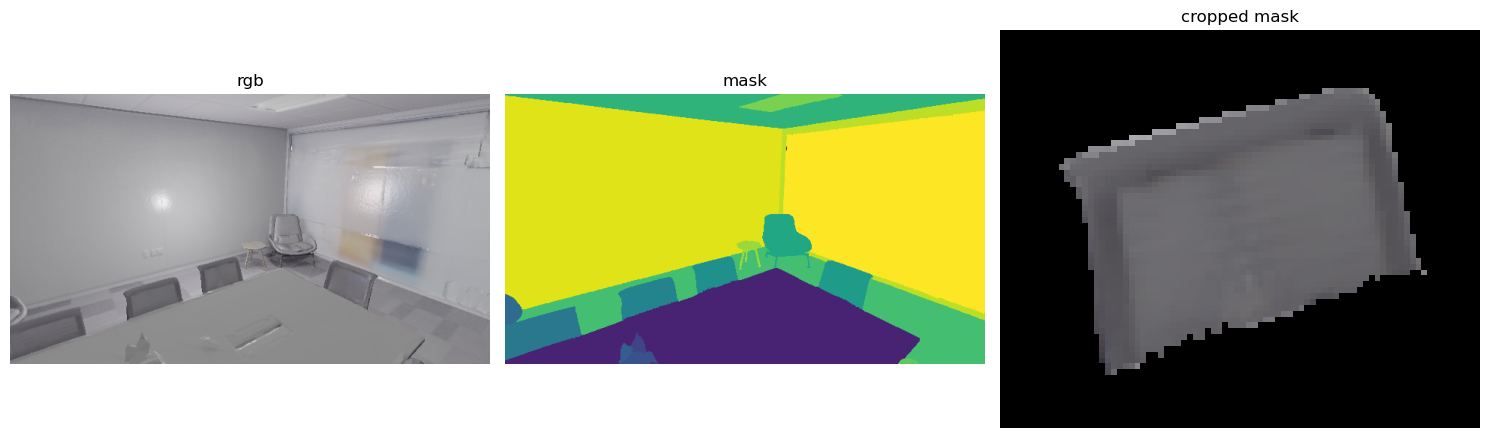

In [12]:
plot_rgb_mask_crop_pair("data/processed/office4", 11, 160, 20020, 20020)

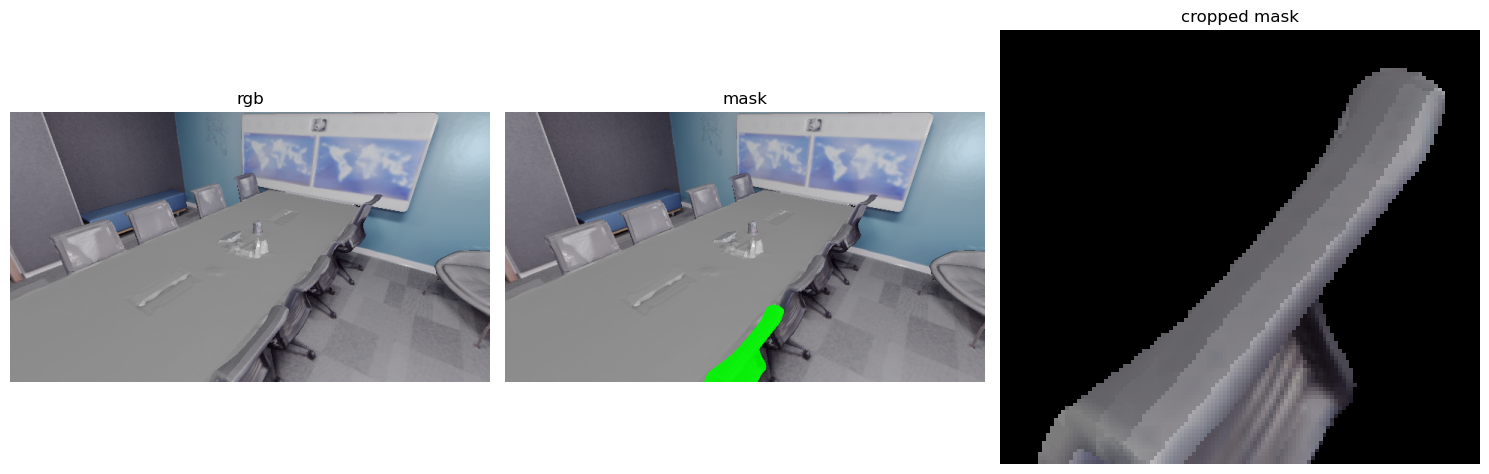

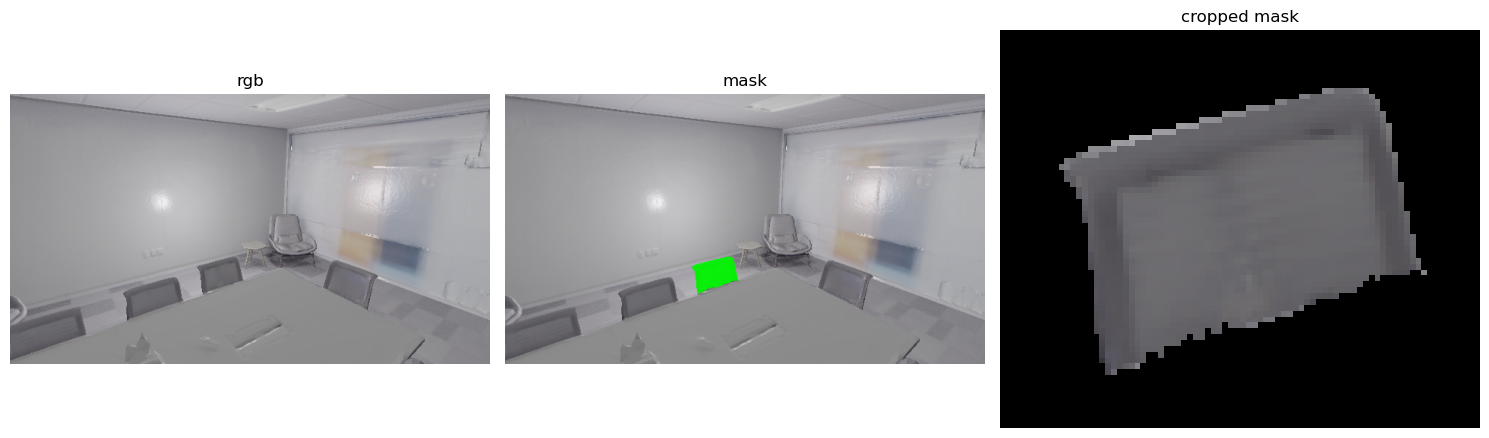

In [13]:
plot_rgb_overlay_crop_pair("data/processed/office4", 11, 160, 20020, 20020)

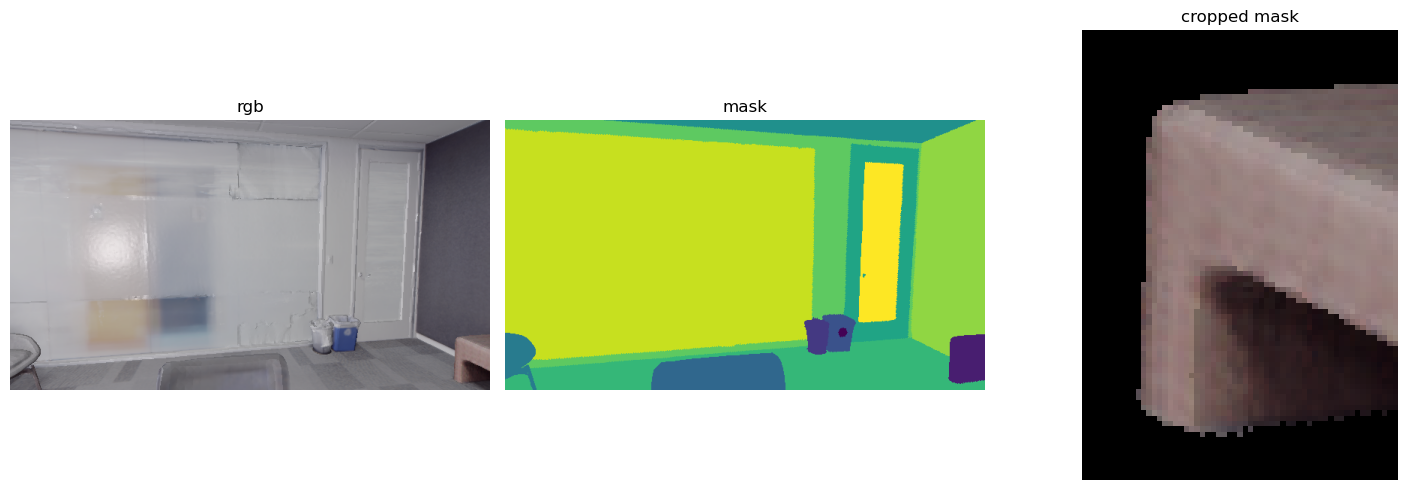

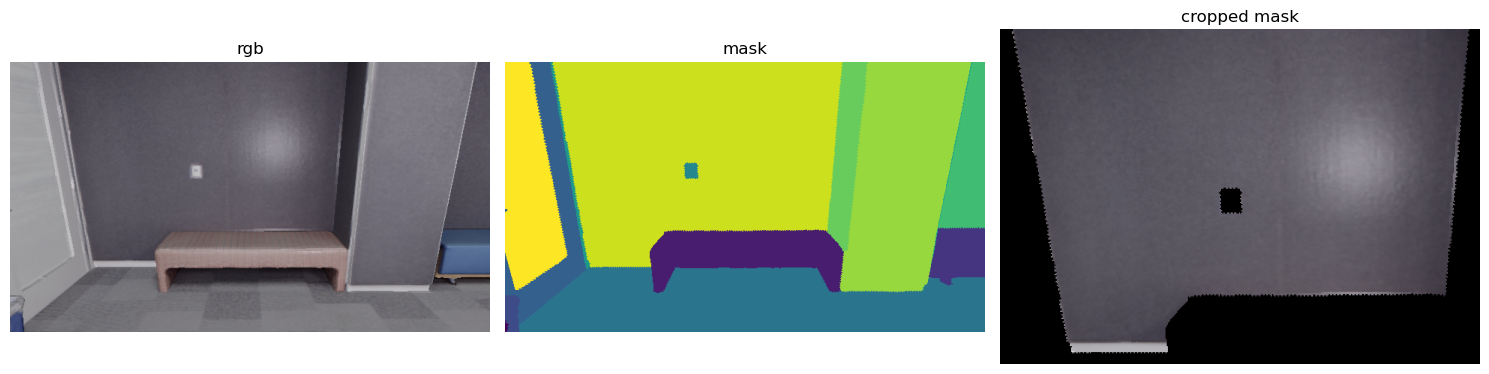

In [13]:
plot_rgb_mask_crop_pair("data/processed/office4", 124, 48, 8051, 93054)

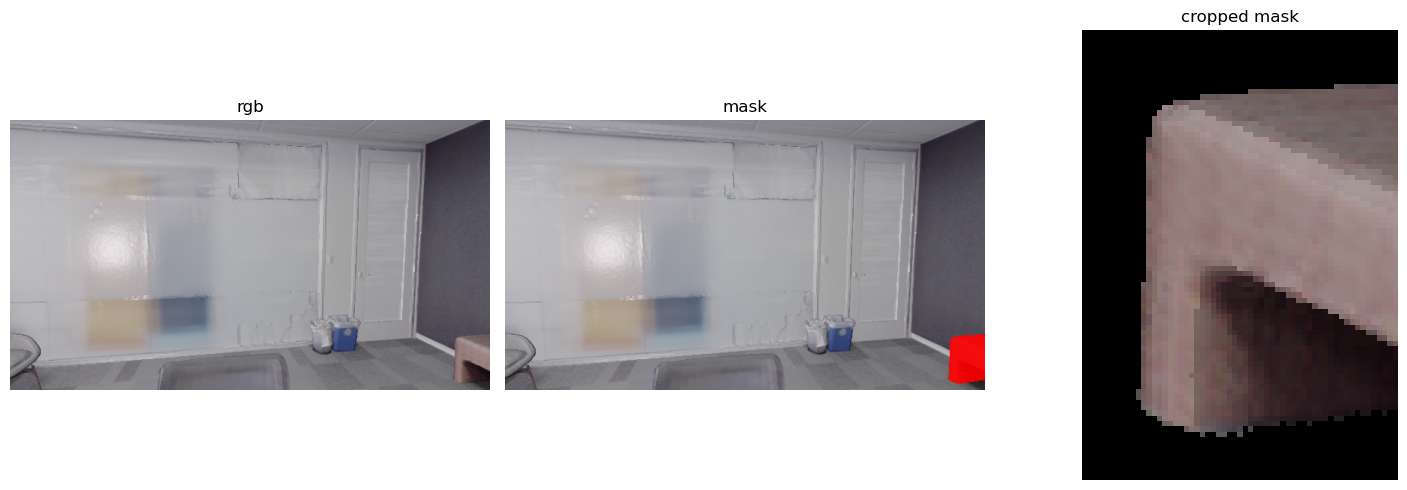

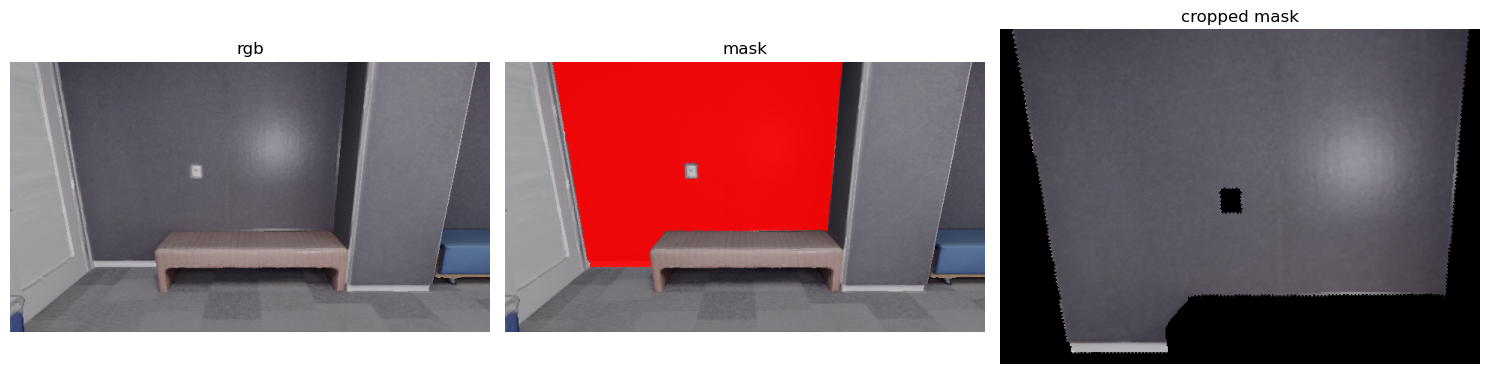

In [14]:
plot_rgb_overlay_crop_pair("data/processed/office4", 124, 48, 8051, 93054)

#### With global views of instance mask

This function can be used to plot the non-cropped mask too for a specific instance if it is not clear where the cropped one is located on the image.

In [14]:
from src.utils.image_processing import load_view
from src.visualization.visualization import plot_imgs

def plot_with_noncropped_mask(root_dir, view, instance):
    rgb, mask = load_view(f"{root_dir}/{view}")
    crop = extract_instance_crop(rgb, mask, instance)
    m = (mask == instance)
    noncrop = np.zeros_like(rgb)
    noncrop[m] = np.array(rgb)[m]
    plot_imgs(rgb, remap_mask(mask), crop, noncrop, titles=["rgb", "full mask", "cropped instance mask", "non-cropped instance mask"])

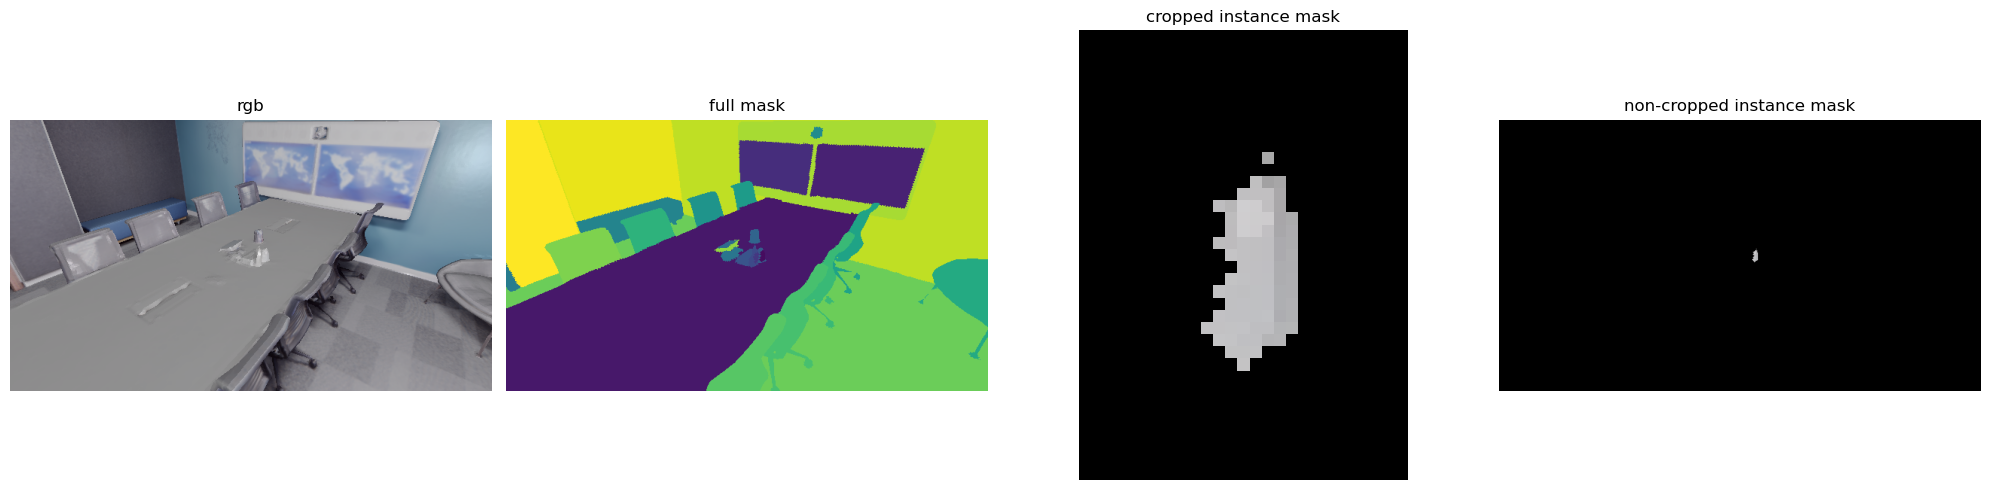

In [15]:
plot_with_noncropped_mask("data/processed/office4", 11, 1)

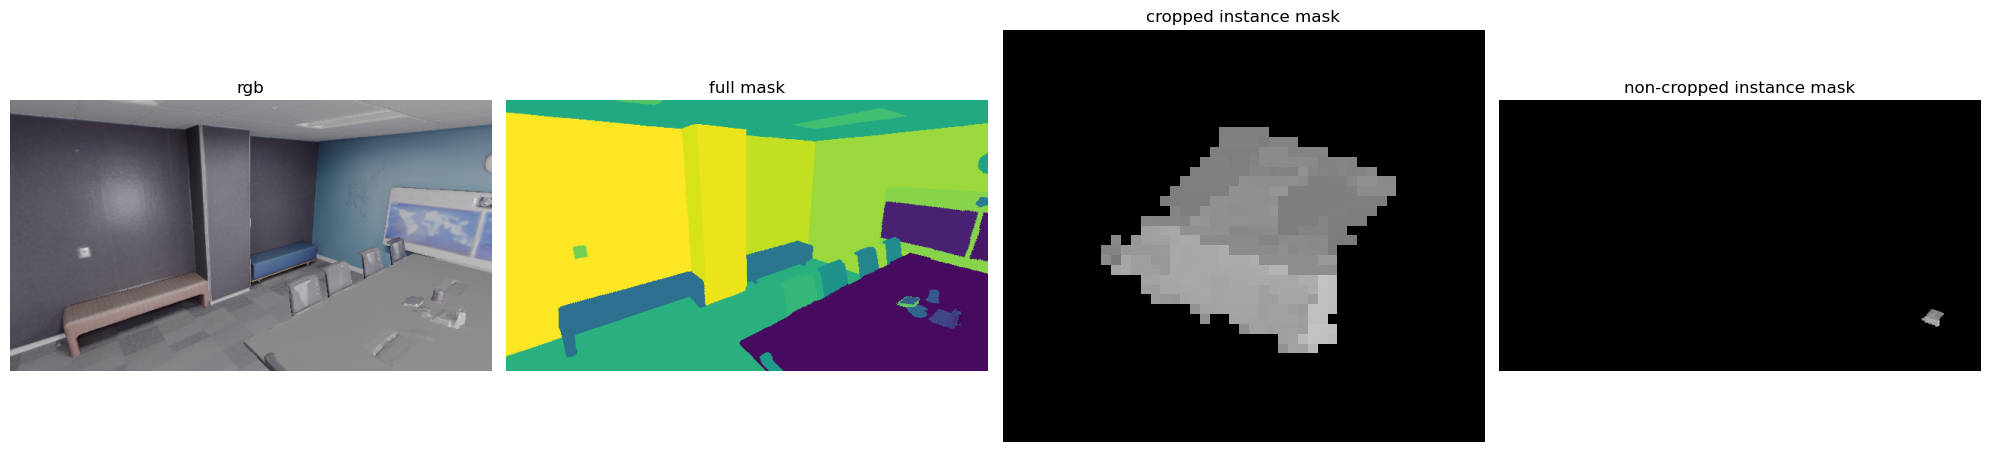

In [16]:
plot_with_noncropped_mask("data/processed/office4", 32, 39)

#### Inspecting top difficult pairs

In [17]:
!scripts/aggregate.sh

mode: base

==================== GLOBAL STATS ====================
Accuracy: 0.7683 | F1: 0.7977 | Precision: 0.7173 | Recall: 0.8984

==================== TOP 30 SPECIFIC OBJECT FAILURES ====================
  scene  inst_i  inst_j           type  fail_count
office4       1       1 False Negative           3
office4   93035   93054 False Positive           3
  room2   93043   93043 False Negative           3
  room2   98001   98001 False Negative           3
office4      58   92023 False Positive           2
  room2   97060   97060 False Negative           2
office4   40014   56021 False Positive           2
  room2   12019   12038 False Positive           2
office4      26      58 False Positive           2
  room2   20007   20007 False Negative           2
office4   20015   47048 False Positive           2
office4      57      57 False Negative           2
office4      39   47048 False Positive           2
office4      43      43 False Negative           2
office4   47071   93056 Fa

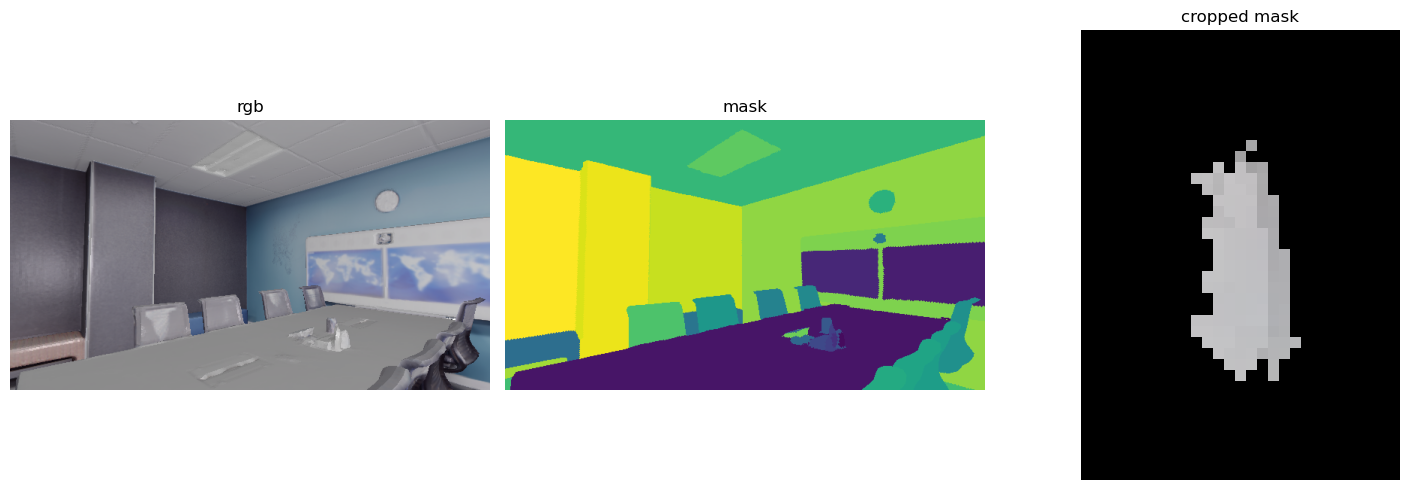

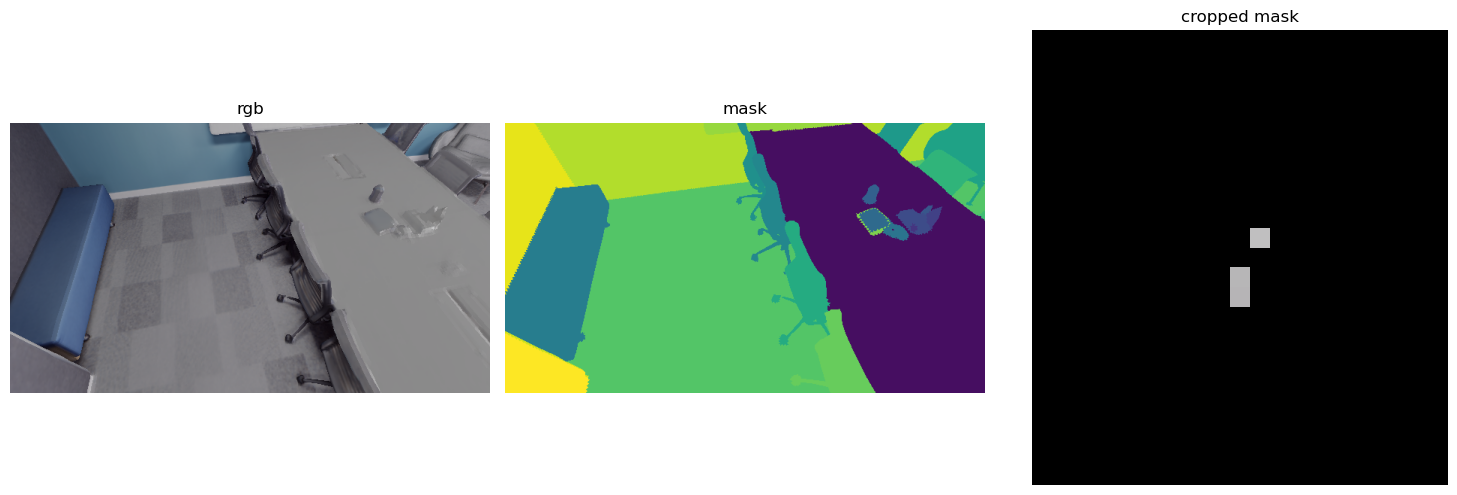

In [18]:
v1, v2 = dataset.instance_pairs[1][0]
plot_rgb_mask_crop_pair("data/processed/office4", v1.name, v2.name, 1, 1)